In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 77749249.16it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 69698327.86it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29791257.17it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14498119.31it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data.data[0].size()

torch.Size([28, 28])

In [6]:
train_data.targets[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [7]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),

    'test': DataLoader(test_data,
                       batch_size=100,
                       shuffle=True,
                       num_workers=1),
}

In [8]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f64b44cf3d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f64b44ce8c0>}

In [54]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ModelCNN(nn.Module):
  def __init__(self):
    super(ModelCNN, self).__init__()
    #Each output channel corresponds to a distinct convolutional kernel (matrix)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d(0.5)
    # input of linear layer comes from 20 channels * 4x4 matrix
    self.fully_connected1 = nn.Linear(320, 50)
    self.fully_connected2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2)) # output 10 of 13x13 feature maps
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # output 20 of 4x4 feature maps
    x = x.view(-1, 320) # flatten to pass to linear layer
    x = F.relu(self.fully_connected1(x))
    x = F.dropout(x, training=self.training, p=0.6)
    x = self.fully_connected2(x)

    return F.softmax(x)


In [ ]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7c2fcc6c95d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7c2fcc6c8d90>}

In [61]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ModelCNN().to(device) # move tensors to gpu

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

# print(model.parameters())
def train(epoch):
  model.train() # set model into training mode
  for batch_id, (data, target) in enumerate(loaders['train']):
    data, target = data.to(device), target.to(device)

    # Backpropagation block
    optimizer.zero_grad()             # zero out accumulated gradients
    output = model(data)              # feedforward
    loss = loss_fn(output, target)    # get loss
    loss.backward()                   # backprop calculate derivatives
    optimizer.step()                  # update weights by step size
    if batch_id % 50 == 0:
      print(f'Train Epoch: {epoch} [{batch_id * len(data)}/{len(loaders["train"].dataset)} ({batch_id / len(loaders["train"]):.0%})]\t{loss.item():.6}')


def test():
  model.eval() # set model into evaluation mode

  test_loss = 0
  correct = 0

  with torch.no_grad(): # turn off parameter update
    for data, target in loaders['test']:
      data, target = data.to(device), target.to(device)
      output = model(data) # feedforward, returns tensor with 10 softmax predicts
      # print("\n\nOutput\n", output[0])
      # print("\n\nTrue target\n", target[0])
      test_loss += loss_fn(output, target).item()
      pred = output.argmax(dim=1, keepdim=True) # picks most probable class from network output
      # print("\n\nPredicted after argmax\n", target[0])
      correct += pred.eq(target.view_as(pred)).sum().item() # compare predicts and true targets

    test_loss /= len(loaders["test"].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({correct / len(loaders["test"].dataset):0%}\n)')

In [59]:
test()

<ipython-input-54-747dd31bb7e2>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)




Output
 tensor([0.0901, 0.0865, 0.0990, 0.0933, 0.1039, 0.1068, 0.1089, 0.1132, 0.0905,
        0.1079])


True target
 tensor(4)


Predicted after argmax
 tensor(4)


Output
 tensor([0.0909, 0.0884, 0.0954, 0.0963, 0.1031, 0.1040, 0.1060, 0.1150, 0.0921,
        0.1088])


True target
 tensor(2)


Predicted after argmax
 tensor(2)


Output
 tensor([0.0906, 0.0869, 0.0989, 0.0948, 0.1043, 0.1032, 0.1090, 0.1131, 0.0915,
        0.1077])


True target
 tensor(9)


Predicted after argmax
 tensor(9)


Output
 tensor([0.0893, 0.0881, 0.0968, 0.0951, 0.1044, 0.1027, 0.1068, 0.1169, 0.0923,
        0.1076])


True target
 tensor(7)


Predicted after argmax
 tensor(7)


Output
 tensor([0.0902, 0.0885, 0.0982, 0.0935, 0.1040, 0.1048, 0.1104, 0.1118, 0.0902,
        0.1084])


True target
 tensor(7)


Predicted after argmax
 tensor(7)


Output
 tensor([0.0912, 0.0857, 0.0971, 0.0959, 0.1029, 0.1025, 0.1079, 0.1151, 0.0928,
        0.1090])


True target
 tensor(8)


Predicted after argmax
 te

In [56]:
for epoch in range(1, 11):
  train(epoch)

test()

<ipython-input-54-747dd31bb7e2>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	2.30095
Train Epoch: 1 [5000/60000 (8%)]	2.17428
Train Epoch: 1 [10000/60000 (17%)]	1.85821
Train Epoch: 1 [15000/60000 (25%)]	1.8202
Train Epoch: 1 [20000/60000 (33%)]	1.92113
Train Epoch: 1 [25000/60000 (42%)]	1.75403
Train Epoch: 1 [30000/60000 (50%)]	1.70062
Train Epoch: 1 [35000/60000 (58%)]	1.68241
Train Epoch: 1 [40000/60000 (67%)]	1.74241
Train Epoch: 1 [45000/60000 (75%)]	1.67039
Train Epoch: 1 [50000/60000 (83%)]	1.65131
Train Epoch: 1 [55000/60000 (92%)]	1.62463
Train Epoch: 2 [0/60000 (0%)]	1.67537
Train Epoch: 2 [5000/60000 (8%)]	1.61891
Train Epoch: 2 [10000/60000 (17%)]	1.66621
Train Epoch: 2 [15000/60000 (25%)]	1.61469
Train Epoch: 2 [20000/60000 (33%)]	1.58842
Train Epoch: 2 [25000/60000 (42%)]	1.60604
Train Epoch: 2 [30000/60000 (50%)]	1.67823
Train Epoch: 2 [35000/60000 (58%)]	1.64501
Train Epoch: 2 [40000/60000 (67%)]	1.57229
Train Epoch: 2 [45000/60000 (75%)]	1.54566
Train Epoch: 2 [50000/60000 (83%)]	1.58607
Train Epoch: 2 [55000/6000

In [63]:
test()

<ipython-input-54-747dd31bb7e2>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)



Test set: Average loss: 0.0230, Accuracy 1034/10000 (10.340000%
)


In [27]:
for param in model.parameters():
  print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([10, 1, 5, 5])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])
<class 'torch.nn.parameter.Parameter'> torch.Size([20, 10, 5, 5])
<class 'torch.nn.parameter.Parameter'> torch.Size([20])
<class 'torch.nn.parameter.Parameter'> torch.Size([50, 320])
<class 'torch.nn.parameter.Parameter'> torch.Size([50])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 50])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


Prediction: 9


<ipython-input-54-747dd31bb7e2>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


<function matplotlib.pyplot.show(close=None, block=None)>

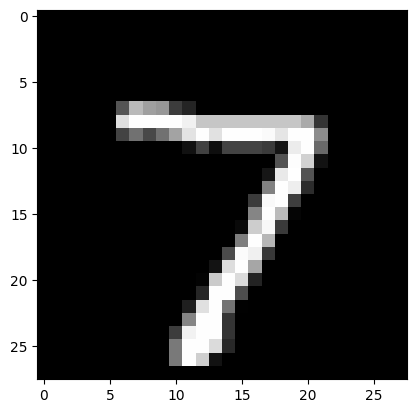

In [109]:
import matplotlib.pyplot as plt

model.eval()
data, target = test_data[0]



data = data.unsqueeze(0).to(device)
data.size()
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show

In [88]:
import torch

# Example tensor
tensor = torch.tensor([[1, 2, 3], [4,5,6]])
print("Original tensor:\n", tensor)

# Unsqueezing along dimension 0
unsqueeze_result = tensor.unsqueeze(-1)
print("\nUnsqueezed tensor:\n", tensor.unsqueeze(0), "\nShape:", tensor.unsqueeze(0).shape)
print("\nUnsqueezed tensor:\n", tensor.unsqueeze(-1), "\nShape:", tensor.unsqueeze(1).shape)
print("\nUnsqueezed tensor:\n", tensor.unsqueeze(-2), "\nShape:", tensor.unsqueeze(2).shape)


print("\nOriginal tensor shape:", tensor.shape)  # Output: torch.Size([3])


Original tensor:
 tensor([[1, 2, 3],
        [4, 5, 6]])

Unsqueezed tensor:
 tensor([[[1, 2, 3],
         [4, 5, 6]]]) 
Shape: torch.Size([1, 2, 3])

Unsqueezed tensor:
 tensor([[[1],
         [2],
         [3]],

        [[4],
         [5],
         [6]]]) 
Shape: torch.Size([2, 1, 3])

Unsqueezed tensor:
 tensor([[[1, 2, 3]],

        [[4, 5, 6]]]) 
Shape: torch.Size([2, 3, 1])

Original tensor shape: torch.Size([2, 3])


In [105]:
# Example tensor
tensor = torch.tensor([[[[1, 2, 3], [4,5,6]]]])
print("Original tensor:\n", tensor, "\nShape:", tensor.shape)

# Unsqueezing along dimension 0
unsqueeze_result = tensor.unsqueeze(-1)
print("\nUnsqueezed tensor:\n", tensor.squeeze(0), "\nShape:", tensor.squeeze(0).shape)
print("\nUnsqueezed tensor:\n", tensor.squeeze(1), "\nShape:", tensor.squeeze(1).shape)
print("\nUnsqueezed tensor:\n", tensor.squeeze(-2), "\nShape:", tensor.squeeze(-2).shape)


print("\nOriginal tensor shape:", tensor.shape)  # Output: torch.Size([3])


Original tensor:
 tensor([[[[1, 2, 3],
          [4, 5, 6]]]]) 
Shape: torch.Size([1, 1, 2, 3])

Unsqueezed tensor:
 tensor([[[1, 2, 3],
         [4, 5, 6]]]) 
Shape: torch.Size([1, 2, 3])

Unsqueezed tensor:
 tensor([[[1, 2, 3],
         [4, 5, 6]]]) 
Shape: torch.Size([1, 2, 3])

Unsqueezed tensor:
 tensor([[[[1, 2, 3],
          [4, 5, 6]]]]) 
Shape: torch.Size([1, 1, 2, 3])

Original tensor shape: torch.Size([1, 1, 2, 3])
